## 使用U-Net提取建筑足迹

数据：https://www.kaggle.com/datasets/utkarshsaxenadn/mapping-challenge-subset/data

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torch.nn.functional as F

import time
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from glob import glob
from osgeo import gdal

# 可视化
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
import torch
import os
import numpy as np
import pandas as pd
from osgeo import gdal
import torchvision
import matplotlib


print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"gdal: {gdal.__version__}")
# print(f"plotly: {plotly.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

numpy: 2.0.1+cu117
numpy: 1.24.4
pandas: 2.1.1
gdal: 3.6.2
matplotlib: 3.7.1


In [3]:
import os
import torch

# 配置参数
BATCH_SIZE = 32
IMAGE_SIZE = (512, 512)
IMAGE_DIR = "MappingChallenge-Subset/images"
MASK_DIR = "MappingChallenge-Subset/masks"
PROGRESS_DIR = "./ModelProgress"

# 创建进度保存目录
if not os.path.exists(PROGRESS_DIR):
    os.makedirs(PROGRESS_DIR)

# 随机种子设置
SEED = 123
VALIDATION_SIZE = 32

# 设置PyTorch的随机种子以保证可重复性
torch.manual_seed(SEED)
# 如果使用CUDA，也需要设置CUDA的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

NUM_WORKERS = os.cpu_count()  # CPU核心数

### 图像处理和可视化

In [4]:
# 定义图像转换管道
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # 转换为Tensor并归一化到[0,1]范围
])

def decode_image(file_path):
    """
    从给定文件路径解码并预处理图像
    
    Args:
        file_path (str): 图像文件的路径
        
    Returns:
        torch.Tensor: 解码并预处理后的图像张量，形状为[C, H, W]
    """
    # 使用PIL读取图像
    image = Image.open(file_path).convert('RGB')  # 确保是RGB格式
    # 应用转换
    image = transform(image)
    return image

def decode_masks(file_path):
    """
    从文件路径解码掩码图像
    
    Args:
        file_path (str): 掩码图像的文件路径
        
    Returns:
        torch.Tensor: 解码后的掩码图像张量，形状为[1, H, W]
    """
    # 使用PIL读取图像，转为灰度图
    mask_image = Image.open(file_path).convert('L')  # 转为灰度图
    # 应用转换
    mask_image = transform(mask_image)
    # 保持单通道用于二进制掩码
    return mask_image

def show_image(image, alpha=1, cmap=None, title=None):
    """显示图像，处理PyTorch张量格式（通道在前 -> 通道在后）"""
    # 如果是张量，转换为numpy数组并调整通道顺序
    if isinstance(image, torch.Tensor):
        # 从[C, H, W]转换为[H, W, C]
        image = image.permute(1, 2, 0).numpy()
        # 如果是单通道，去除通道维度
        if image.shape[-1] == 1:
            image = image.squeeze(-1)
    # 如果是numpy数组且通道在前，转换为通道在后
    elif isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[0] in [1, 3]:
        # 从[C, H, W]转换为[H, W, C]
        image = image.transpose(1, 2, 0)
        # 单通道图像去除通道维度
        if image.shape[-1] == 1:
            image = image.squeeze(-1)
    
    # 确保像素值在合理范围内（0-1）
    if image.max() > 1.0:
        image = image / 255.0  # 如果是0-255范围，转换为0-1
    
    if image.ndim == 3 and image.shape[-1] == 3:
        plt.imshow(image, alpha=alpha)
    else:
        plt.imshow(image, alpha=alpha, cmap=cmap or 'gray')
    plt.title(title)
    plt.axis('off')
    
def show_image_masks(dataset, n_rows=5, n_cols=3, figsize=(10, 15)):
    """
    从给定数据集中显示图像及其对应掩码的网格
    
    Args:
        dataset (torch.utils.data.Dataset): 包含图像和掩码对的数据集
        n_rows (int, optional): 网格中的行数. 默认值为5.
        n_cols (int, optional): 网格中的列数. 默认值为3.
        figsize (tuple, optional): 绘图的图大小. 默认值为(10, 15).
    """
    # 创建数据加载器
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=n_rows * (n_cols // 3),  # 每组3列显示一个样本的3种状态
        shuffle=True
    )
    
    # 获取一个批次的数据
    images, masks = next(iter(dataloader))

    plt.figure(figsize=figsize)
    for i in range(n_rows):
        for j in range(n_cols // 3):
            idx = i * (n_cols // 3) + j
            if idx >= len(images):
                break
                
            # 原始图像
            plt.subplot(n_rows, n_cols, i * n_cols + j * 3 + 1)
            show_image(images[idx], title="Aerial Imagery")
            
            # 掩码图像
            plt.subplot(n_rows, n_cols, i * n_cols + j * 3 + 2)
            show_image(masks[idx], cmap='gray', title="Image Mask")
            
            # 叠加显示
            plt.subplot(n_rows, n_cols, i * n_cols + j * 3 + 3)
            show_image(images[idx])
            show_image(masks[idx], alpha=0.5, cmap='jet', title="Overlapping")

    plt.tight_layout()
    plt.show()

### 加载数据

In [5]:
train_image_paths = sorted(glob(IMAGE_DIR + "/*"))
train_mask_paths = [path.replace("images", "masks") for path in train_image_paths]

print(f"训练图像数量: {len(train_image_paths)}")
print(f"训练掩码数量: {len(train_mask_paths)}")

训练图像数量: 2000
训练掩码数量: 2000


In [6]:
# 定义自定义数据集类
class ImageMaskDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 加载图像和掩码
        image = decode_image(self.image_paths[idx])
        mask = decode_masks(self.mask_paths[idx])
        
        return image, mask

# 创建数据集实例
dataset = ImageMaskDataset(train_image_paths, train_mask_paths)

# 创建数据加载器，对应TF的数据管道操作
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,  # 进程数
    drop_last=True  # 是否保留最后一个不完整的批次
)

# 重复2次数据
from torch.utils.data import ConcatDataset
dataset_repeated = ConcatDataset([dataset] * 2)

# 使用重复后的数据集创建数据加载器
dataloader_repeated = DataLoader(
    dataset_repeated,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

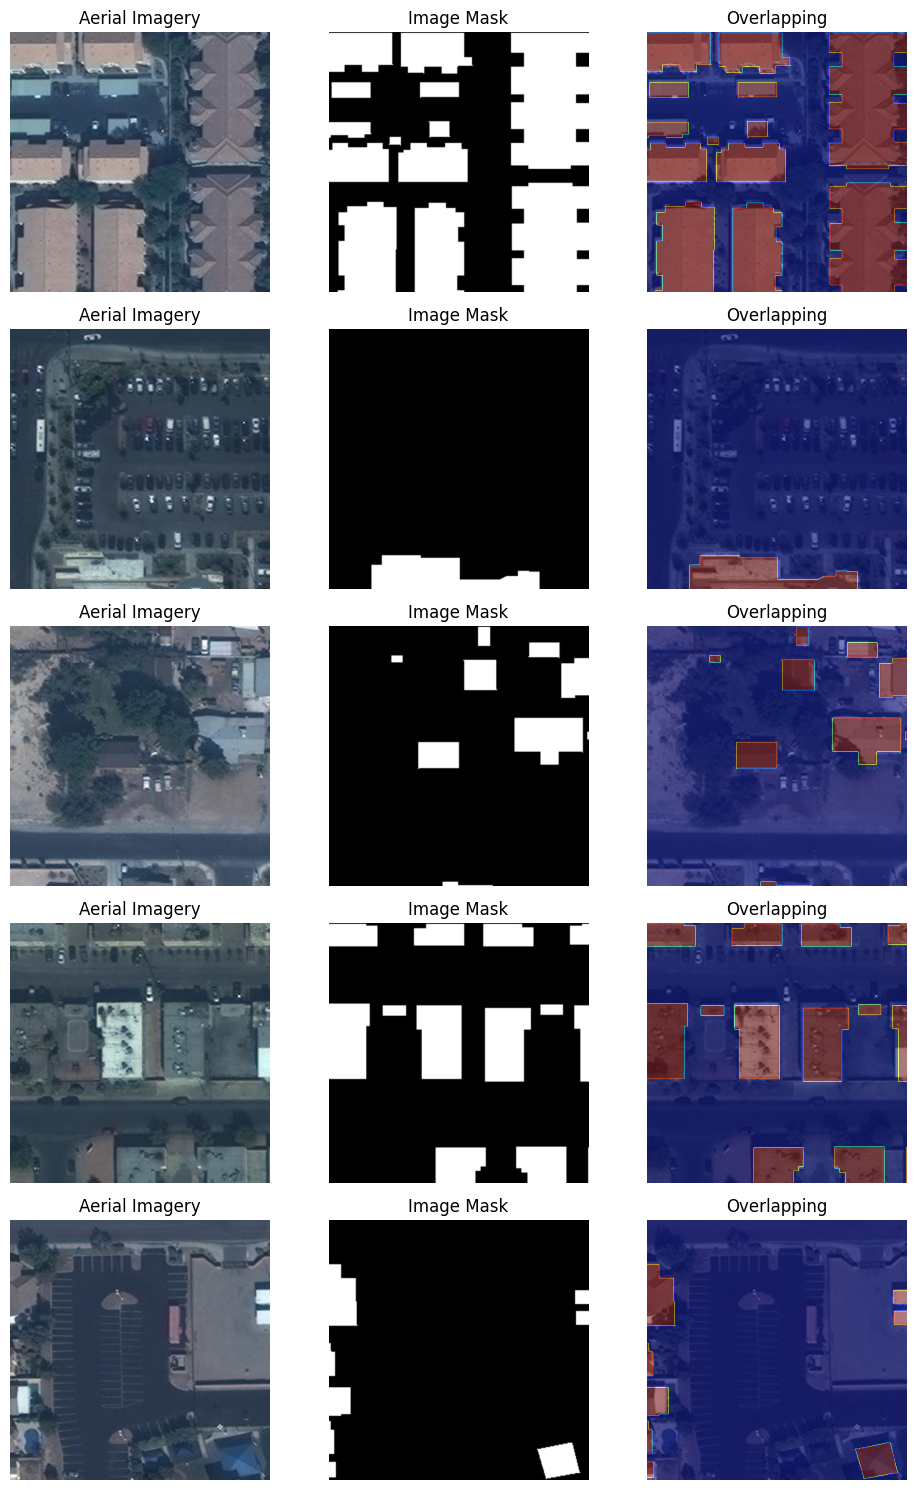

In [7]:
show_image_masks(dataset)

In [8]:
# 计算验证集大小（确保不超过数据集总大小）
valid_size = min(VALIDATION_SIZE, len(dataset))
train_size = len(dataset) - valid_size

# 生成随机索引
indices = torch.randperm(len(dataset)).tolist()

# 分割索引为训练集和验证集
valid_indices = indices[:valid_size]
train_indices = indices[valid_size:]

# 创建训练集和验证集子集
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)

# 创建数据加载器
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # 验证集不需要打乱
    num_workers=NUM_WORKERS,
    drop_last=False  # 验证集保留最后一个不完整批次
)

# 计算样本数量
train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

print(f"Training   Samples: {train_samples}")
print(f"Validation Samples: {valid_samples}")

Training   Samples: 1968
Validation Samples: 32


### Unet Model

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, filters, rate=None, pooling=True):
        super(EncoderBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        # 第一次卷积
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=filters,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        # 第二次卷积
        self.conv2 = nn.Conv2d(
            in_channels=filters,
            out_channels=filters,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        
        # ReLU激活函数
        self.relu = nn.ReLU(inplace=True)
        
        # 最大池化层
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout层
        if self.rate is not None:
            self.drop = nn.Dropout2d(p=rate)
        
        # 初始化权重 (对应he_normal)
        self._initialize_weights()
    
    def _initialize_weights(self):
        """使用He初始化方法初始化卷积层权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 第一次卷积 + ReLU
        x = self.conv1(x)
        x = self.relu(x)
        
        # 可选的dropout
        if self.rate is not None:
            x = self.drop(x)
        
        # 第二次卷积 + ReLU
        x = self.conv2(x)
        x = self.relu(x)
        
        # 可选的池化
        if self.pooling:
            # 返回池化后的值和池化前的值(用于跳跃连接)
            y = self.pool(x)
            return y, x
        else:
            return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, filters, rate=None):
        super(DecoderBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        
        # 转置卷积(上采样)
        self.convT = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1  # 确保上采样后尺寸正确
        )
        
        # 第一次卷积 (输入通道数是filters*2，因为拼接了跳跃连接)
        self.conv1 = nn.Conv2d(
            in_channels=filters * 2,
            out_channels=filters,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        
        # 第二次卷积
        self.conv2 = nn.Conv2d(
            in_channels=filters,
            out_channels=filters,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        
        # ReLU激活函数
        self.relu = nn.ReLU(inplace=True)
        
        # Dropout层
        if self.rate is not None:
            self.drop = nn.Dropout2d(p=rate)
        
        # 初始化权重
        self._initialize_weights()
    
    def _initialize_weights(self):
        """使用He初始化方法初始化卷积层权重"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x, short_x):
        # 上采样
        x = self.convT(x)
        x = self.relu(x)
        
        # 拼接跳跃连接 (PyTorch中通道维度是第1维)
        c = torch.cat([x, short_x], dim=1)
        
        # 第一次卷积 + ReLU
        x = self.conv1(c)
        x = self.relu(x)
        
        # 可选的dropout
        if self.rate is not None:
            x = self.drop(x)
        
        # 第二次卷积 + ReLU
        x = self.conv2(x)
        x = self.relu(x)
        
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # 编码器部分
        self.encoder1 = EncoderBlock(in_channels=3, filters=16, rate=0.1)
        self.encoder2 = EncoderBlock(in_channels=16, filters=32, rate=0.1)
        self.encoder3 = EncoderBlock(in_channels=32, filters=64, rate=0.2)
        self.encoder4 = EncoderBlock(in_channels=64, filters=128, rate=0.2)
        
        # 编码层（瓶颈）
        self.bottleneck = EncoderBlock(in_channels=128, filters=256, rate=0.3, pooling=False)
        
        # 解码器部分
        self.decoder1 = DecoderBlock(in_channels=256, filters=128, rate=0.2)
        self.decoder2 = DecoderBlock(in_channels=128, filters=64, rate=0.2)
        self.decoder3 = DecoderBlock(in_channels=64, filters=32, rate=0.1)
        self.decoder4 = DecoderBlock(in_channels=32, filters=16, rate=0.1)
        
        # 输出层
        self.output_conv = nn.Conv2d(
            in_channels=16,
            out_channels=1,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 编码器前向传播
        p1, c1 = self.encoder1(x)
        p2, c2 = self.encoder2(p1)
        p3, c3 = self.encoder3(p2)
        p4, c4 = self.encoder4(p3)
        
        # 瓶颈层
        c5 = self.bottleneck(p4)
        
        # 解码器前向传播
        d1 = self.decoder1(c5, c4)
        d2 = self.decoder2(d1, c3)
        d3 = self.decoder3(d2, c2)
        d4 = self.decoder4(d3, c1)
        
        # 输出层
        outputs = self.output_conv(d4)
        outputs = self.sigmoid(outputs)
        
        return outputs

In [10]:
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [11]:
print(model)

UNet(
  (encoder1): EncoderBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout2d(p=0.1, inplace=False)
  )
  (encoder2): EncoderBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout2d(p=0.1, inplace=False)
  )
  (encoder3): EncoderBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

### 训练模型

In [12]:
# 预先获取验证集图像和掩码（保持每个epoch预测相同图像）
# 从验证数据加载器取一个批次
val_images, val_masks = next(iter(valid_dataloader))
# 移至CPU并转换为numpy
val_images_np = val_images.cpu().numpy()
val_masks_np = val_masks.cpu().numpy()

def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    """
    显示原始图像、真实掩码、预测掩码及不同阈值处理结果
    """
    # 模型切换到评估模式
    model.eval()
    
    # 禁用梯度计算（加速推理）
    with torch.no_grad():
        # 将验证图像移至模型所在设备
        device = next(model.parameters()).device
        val_images_tensor = val_images.to(device)
        # 预测掩码
        pred_masks = model(val_images_tensor)
        # 移至CPU并转换为numpy
        pred_masks_np = pred_masks.cpu().numpy()
    
    # 恢复训练模式
    model.train()
    
    plt.figure(figsize=figsize)
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        # 防止索引超出批次大小
        if i >= len(val_images_np):
            break
        
        # 原始图像
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images_np[i], title="Aerial Imagery")
        
        # 真实掩码
        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks_np[i], title="True Image Mask")
        
        # 预测掩码
        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks_np[i], title="Predicted Image Mask")
        
        # 阈值0.5处理的掩码
        plt.subplot(n_rows, n_cols, i + 3)
        processed_05 = (pred_masks_np[i] >= 0.5).astype(np.float32)
        show_image(processed_05, title="Processed Mask(0.5)")
        
        # 阈值0.7处理的掩码
        plt.subplot(n_rows, n_cols, i + 4)
        processed_07 = (pred_masks_np[i] >= 0.7).astype(np.float32)
        show_image(processed_07, title="Processed Mask(0.7)")
        
        # 叠加显示
        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images_np[i])
        show_image(pred_masks_np[i], cmap='jet', alpha=0.5, title="Overlapping")
    
    # 保存图像（如果指定路径）
    if savepath is not None:
        savepath = os.path.join(PROGRESS_DIR, savepath)
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


class ShowImageMasksCallback:
    """
    每个epoch结束时可视化模型预测结果的回调类
    """
    def __init__(self):
        pass
    
    def on_epoch_end(self, epoch, model):
        """
        在每个epoch结束时调用，显示并保存预测结果
        
        Args:
            epoch (int): 当前epoch编号
            model (torch.nn.Module): 训练的模型
        """
        show_pred_masks(
            model=model,
            n_rows=5,
            savepath=f"ModelPred_Epoch_{epoch}.png",
            figsize=(15, 10)
        )

In [13]:
def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, 
                num_epochs=20, device='cuda'):
    """
    完整的模型训练函数，包含训练、验证、指标跟踪和可视化
    
    Args:
        model: 要训练的PyTorch模型
        train_dataloader: 训练数据加载器
        valid_dataloader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 训练设备（'cuda'或'cpu'）
    
    Returns:
        model: 训练好的模型
        history: 包含训练过程中所有指标的字典
    """
    # 初始化指标跟踪
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': []
    }
    
    # 初始化回调
    pred_callback = ShowImageMasksCallback()
    
    # 记录最佳验证损失（用于保存最佳模型）
    best_val_loss = float('inf')
    
    # 将模型移至指定设备
    model.to(device)
    
    print(f"开始训练，使用设备: {device}")
    print(f"总轮数: {num_epochs}, 训练批次: {len(train_dataloader)}, 验证批次: {len(valid_dataloader)}")
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        history['epochs'].append(epoch)
        
        # -------------------
        # 训练阶段
        # -------------------
        model.train()
        train_running_loss = 0.0
        train_running_acc = 0.0
        train_total = 0
        
        # 使用tqdm显示进度条
        train_pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [训练]")
        
        for images, masks in train_pbar:
            # 将数据移至设备
            images = images.to(device)
            masks = masks.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(images)
            
            # 计算损失
            loss = criterion(outputs, masks)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 计算准确率（二值分类，阈值0.5）
            preds = (outputs >= 0.5).float()
            correct = (preds == masks).sum().item()
            total = masks.numel()  # 总元素数量
            acc = correct / total
            
            # 累计损失和准确率
            train_running_loss += loss.item() * images.size(0)
            train_running_acc += correct
            train_total += total
            
            # 更新进度条
            train_pbar.set_postfix({
                'train_loss': f"{loss.item():.4f}",
                'train_acc': f"{acc:.4f}"
            })
        
        # 计算平均训练损失和准确率
        avg_train_loss = train_running_loss / len(train_dataloader.dataset)
        avg_train_acc = train_running_acc / train_total
        
        # -------------------
        # 验证阶段
        # -------------------
        model.eval()
        val_running_loss = 0.0
        val_running_acc = 0.0
        val_total = 0
        
        # 禁用梯度计算
        with torch.no_grad():
            val_pbar = tqdm(valid_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [验证]")
            
            for images, masks in val_pbar:
                # 将数据移至设备
                images = images.to(device)
                masks = masks.to(device)
                
                # 前向传播
                outputs = model(images)
                
                # 计算损失
                loss = criterion(outputs, masks)
                
                # 计算准确率
                preds = (outputs >= 0.5).float()
                correct = (preds == masks).sum().item()
                total = masks.numel()
                acc = correct / total
                
                # 累计损失和准确率
                val_running_loss += loss.item() * images.size(0)
                val_running_acc += correct
                val_total += total
                
                # 更新进度条
                val_pbar.set_postfix({
                    'val_loss': f"{loss.item():.4f}",
                    'val_acc': f"{acc:.4f}"
                })
        
        # 计算平均验证损失和准确率
        avg_val_loss = val_running_loss / len(valid_dataloader.dataset)
        avg_val_acc = val_running_acc / val_total
        
        # 记录指标
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        
        # 打印 epoch 总结
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s")
        print(f"训练损失: {avg_train_loss:.4f} - 训练准确率: {avg_train_acc:.4f}")
        print(f"验证损失: {avg_val_loss:.4f} - 验证准确率: {avg_val_acc:.4f}")
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(PROGRESS_DIR, 'best_model.pth'))
            print(f"保存最佳模型 (验证损失: {best_val_loss:.4f})")
        
        # 每个epoch结束时显示预测结果
        if epoch %10 == 0:
            pred_callback.on_epoch_end(epoch, model)
        
        # 绘制并保存损失和准确率曲线
        plot_training_history(history, epoch)
    
    return model, history


def plot_training_history(history, epoch):
    """绘制并保存训练过程中的损失和准确率曲线"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['epochs'], history['train_loss'], label='Train')
    plt.plot(history['epochs'], history['val_loss'], label='Val')
    # plt.title(f'训练与验证损失 (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['epochs'], history['train_acc'], label='Train')
    plt.plot(history['epochs'], history['val_acc'], label='Val')
    # plt.title(f'训练与验证准确率 (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # 保存图像
    savepath = os.path.join(PROGRESS_DIR, 'TrainingHistory.png')
    plt.savefig(savepath, bbox_inches='tight')
    plt.close()

开始训练，使用设备: cuda
总轮数: 100, 训练批次: 61, 验证批次: 1


Epoch 1/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, val_loss=0.3825, val_acc=0.7760]



Epoch 1/100 - 38.26s
训练损失: 0.5969 - 训练准确率: 0.6588
验证损失: 0.3825 - 验证准确率: 0.7760
保存最佳模型 (验证损失: 0.3825)


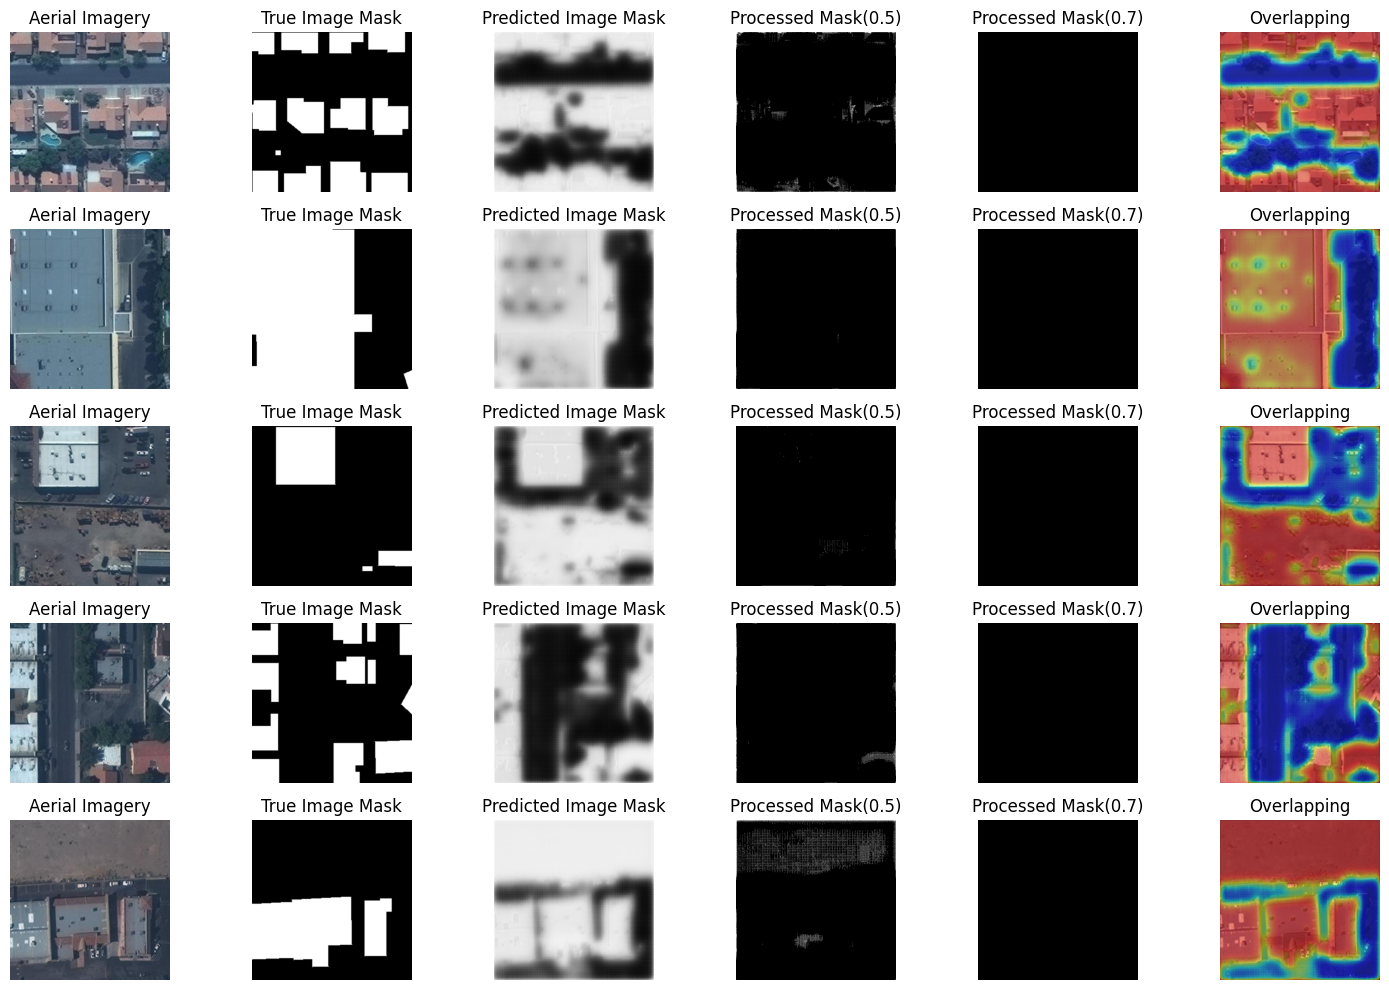

Epoch 2/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, val_loss=0.3797, val_acc=0.8028]



Epoch 2/100 - 38.16s
训练损失: 0.4515 - 训练准确率: 0.7517
验证损失: 0.3797 - 验证准确率: 0.8028
保存最佳模型 (验证损失: 0.3797)


Epoch 3/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, val_loss=0.3638, val_acc=0.8199]



Epoch 3/100 - 37.97s
训练损失: 0.4232 - 训练准确率: 0.7642
验证损失: 0.3638 - 验证准确率: 0.8199
保存最佳模型 (验证损失: 0.3638)


Epoch 4/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, val_loss=0.3438, val_acc=0.8286]



Epoch 4/100 - 38.41s
训练损失: 0.4176 - 训练准确率: 0.7752
验证损失: 0.3438 - 验证准确率: 0.8286
保存最佳模型 (验证损失: 0.3438)


Epoch 5/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, val_loss=0.3298, val_acc=0.8293]



Epoch 5/100 - 38.34s
训练损失: 0.4119 - 训练准确率: 0.7741
验证损失: 0.3298 - 验证准确率: 0.8293
保存最佳模型 (验证损失: 0.3298)


Epoch 6/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, val_loss=0.3390, val_acc=0.8274]



Epoch 6/100 - 38.41s
训练损失: 0.4087 - 训练准确率: 0.7782
验证损失: 0.3390 - 验证准确率: 0.8274


Epoch 7/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, val_loss=0.3319, val_acc=0.8346]



Epoch 7/100 - 38.53s
训练损失: 0.3986 - 训练准确率: 0.7863
验证损失: 0.3319 - 验证准确率: 0.8346


Epoch 8/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, val_loss=0.3146, val_acc=0.8455]



Epoch 8/100 - 38.18s
训练损失: 0.3804 - 训练准确率: 0.7979
验证损失: 0.3146 - 验证准确率: 0.8455
保存最佳模型 (验证损失: 0.3146)


Epoch 9/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, val_loss=0.3101, val_acc=0.8542]



Epoch 9/100 - 38.85s
训练损失: 0.3529 - 训练准确率: 0.8171
验证损失: 0.3101 - 验证准确率: 0.8542
保存最佳模型 (验证损失: 0.3101)


Epoch 10/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, val_loss=0.2664, val_acc=0.8610]



Epoch 10/100 - 38.48s
训练损失: 0.3437 - 训练准确率: 0.8222
验证损失: 0.2664 - 验证准确率: 0.8610
保存最佳模型 (验证损失: 0.2664)


Epoch 11/100 [验证]: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, val_loss=0.2558, val_acc=0.8615]



Epoch 11/100 - 38.87s
训练损失: 0.3339 - 训练准确率: 0.8266
验证损失: 0.2558 - 验证准确率: 0.8615
保存最佳模型 (验证损失: 0.2558)


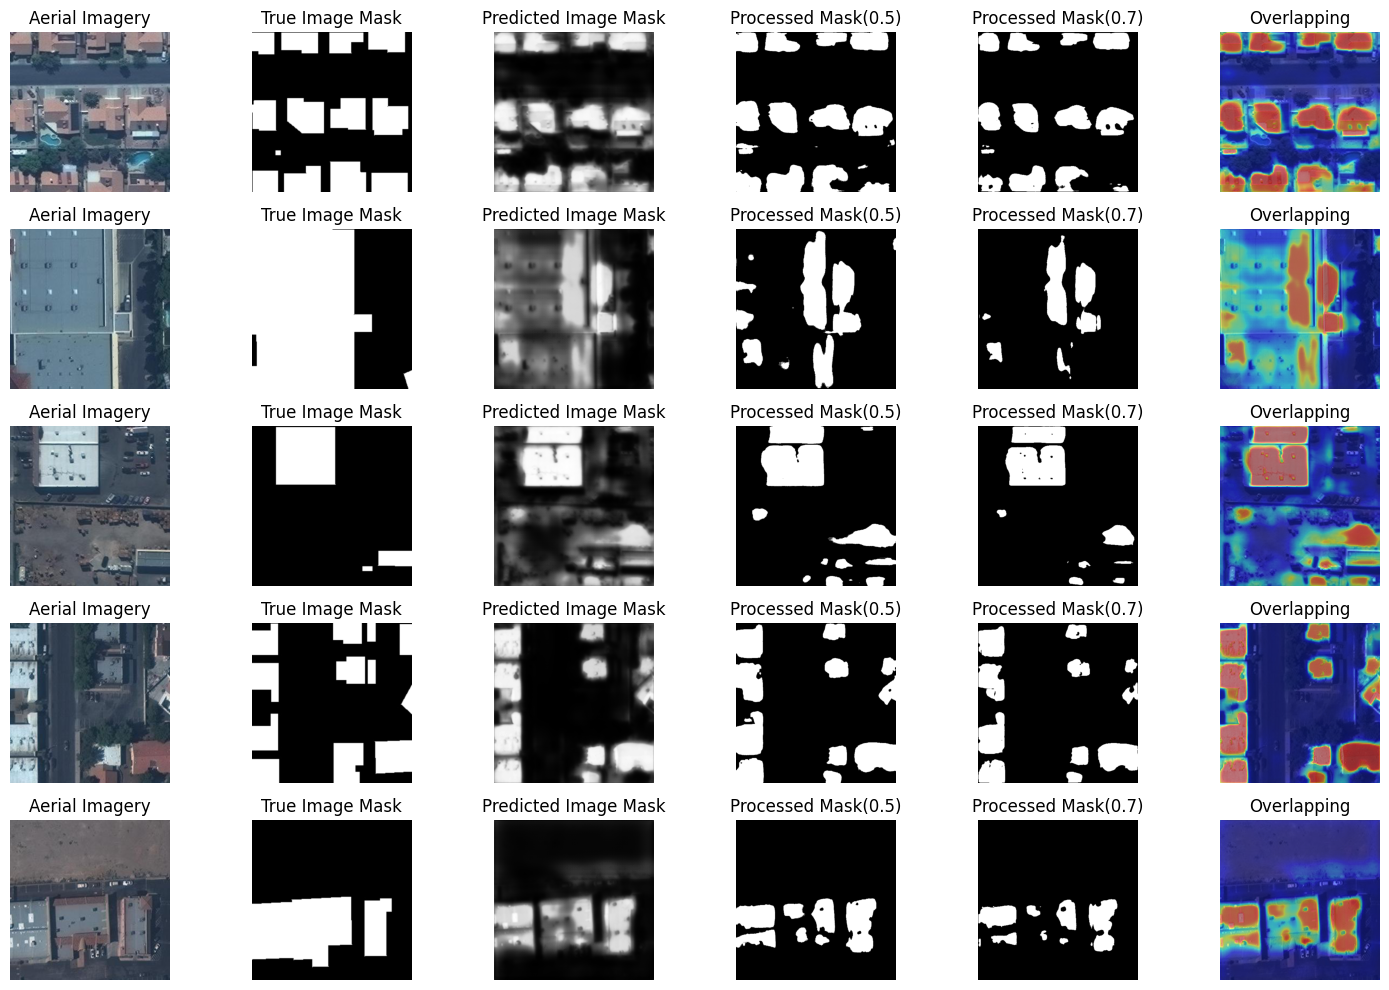

Epoch 12/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, val_loss=0.2441, val_acc=0.8663]



Epoch 12/100 - 37.81s
训练损失: 0.3219 - 训练准确率: 0.8328
验证损失: 0.2441 - 验证准确率: 0.8663
保存最佳模型 (验证损失: 0.2441)


Epoch 13/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, val_loss=0.2479, val_acc=0.8641]



Epoch 13/100 - 37.72s
训练损失: 0.3095 - 训练准确率: 0.8392
验证损失: 0.2479 - 验证准确率: 0.8641


Epoch 14/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, val_loss=0.2419, val_acc=0.8646]



Epoch 14/100 - 37.81s
训练损失: 0.2977 - 训练准确率: 0.8449
验证损失: 0.2419 - 验证准确率: 0.8646
保存最佳模型 (验证损失: 0.2419)


Epoch 15/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, val_loss=0.2219, val_acc=0.8790]



Epoch 15/100 - 37.90s
训练损失: 0.2886 - 训练准确率: 0.8493
验证损失: 0.2219 - 验证准确率: 0.8790
保存最佳模型 (验证损失: 0.2219)


Epoch 16/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, val_loss=0.2271, val_acc=0.8733]



Epoch 16/100 - 38.22s
训练损失: 0.2750 - 训练准确率: 0.8545
验证损失: 0.2271 - 验证准确率: 0.8733


Epoch 17/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, val_loss=0.2120, val_acc=0.8826]



Epoch 17/100 - 37.85s
训练损失: 0.2744 - 训练准确率: 0.8551
验证损失: 0.2120 - 验证准确率: 0.8826
保存最佳模型 (验证损失: 0.2120)


Epoch 18/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, val_loss=0.2229, val_acc=0.8772]



Epoch 18/100 - 37.89s
训练损失: 0.2600 - 训练准确率: 0.8616
验证损失: 0.2229 - 验证准确率: 0.8772


Epoch 19/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, val_loss=0.2020, val_acc=0.8935]



Epoch 19/100 - 37.71s
训练损失: 0.2649 - 训练准确率: 0.8613
验证损失: 0.2020 - 验证准确率: 0.8935
保存最佳模型 (验证损失: 0.2020)


Epoch 20/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, val_loss=0.1824, val_acc=0.8958]



Epoch 20/100 - 37.75s
训练损失: 0.2482 - 训练准确率: 0.8674
验证损失: 0.1824 - 验证准确率: 0.8958
保存最佳模型 (验证损失: 0.1824)


Epoch 21/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, val_loss=0.1928, val_acc=0.8897]



Epoch 21/100 - 38.29s
训练损失: 0.2417 - 训练准确率: 0.8703
验证损失: 0.1928 - 验证准确率: 0.8897


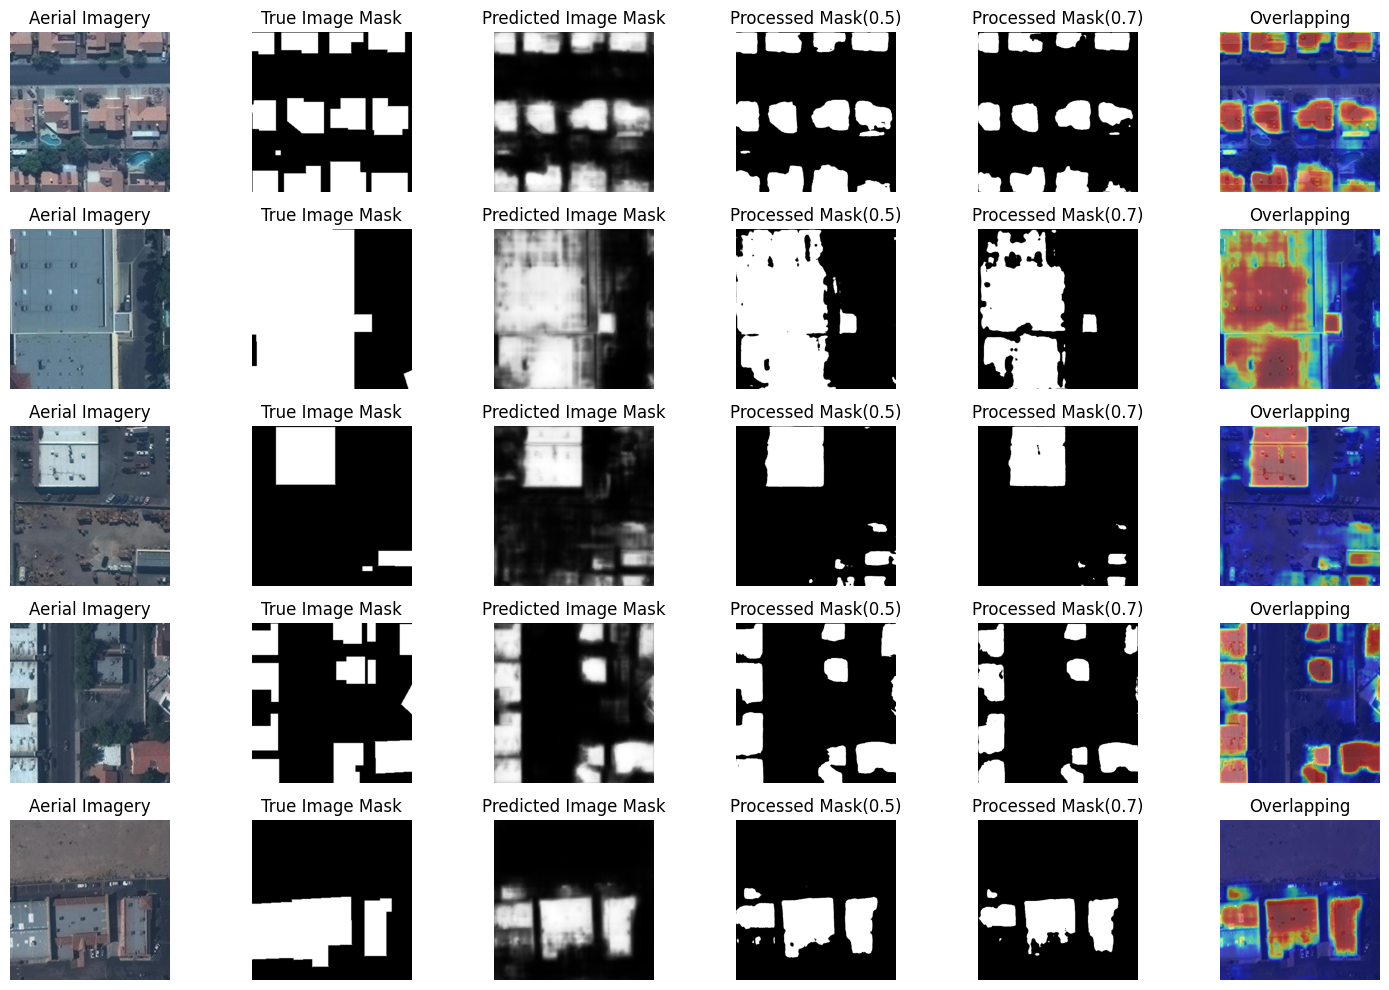

Epoch 22/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, val_loss=0.2177, val_acc=0.8830]



Epoch 22/100 - 37.81s
训练损失: 0.2369 - 训练准确率: 0.8719
验证损失: 0.2177 - 验证准确率: 0.8830


Epoch 23/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, val_loss=0.1883, val_acc=0.8924]



Epoch 23/100 - 38.25s
训练损失: 0.2347 - 训练准确率: 0.8726
验证损失: 0.1883 - 验证准确率: 0.8924


Epoch 24/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, val_loss=0.1726, val_acc=0.9034]



Epoch 24/100 - 38.80s
训练损失: 0.2337 - 训练准确率: 0.8738
验证损失: 0.1726 - 验证准确率: 0.9034
保存最佳模型 (验证损失: 0.1726)


Epoch 25/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, val_loss=0.1841, val_acc=0.9010]



Epoch 25/100 - 38.22s
训练损失: 0.2337 - 训练准确率: 0.8735
验证损失: 0.1841 - 验证准确率: 0.9010


Epoch 26/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, val_loss=0.1787, val_acc=0.9015]



Epoch 26/100 - 38.18s
训练损失: 0.2241 - 训练准确率: 0.8771
验证损失: 0.1787 - 验证准确率: 0.9015


Epoch 27/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, val_loss=0.1654, val_acc=0.9045]



Epoch 27/100 - 38.30s
训练损失: 0.2210 - 训练准确率: 0.8782
验证损失: 0.1654 - 验证准确率: 0.9045
保存最佳模型 (验证损失: 0.1654)


Epoch 28/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, val_loss=0.1689, val_acc=0.9013]



Epoch 28/100 - 38.12s
训练损失: 0.2154 - 训练准确率: 0.8811
验证损失: 0.1689 - 验证准确率: 0.9013


Epoch 29/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, val_loss=0.1660, val_acc=0.9064]



Epoch 29/100 - 38.04s
训练损失: 0.2178 - 训练准确率: 0.8805
验证损失: 0.1660 - 验证准确率: 0.9064


Epoch 30/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, val_loss=0.1567, val_acc=0.9072]



Epoch 30/100 - 38.23s
训练损失: 0.2095 - 训练准确率: 0.8833
验证损失: 0.1567 - 验证准确率: 0.9072
保存最佳模型 (验证损失: 0.1567)


Epoch 31/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, val_loss=0.1630, val_acc=0.9092]



Epoch 31/100 - 38.04s
训练损失: 0.2102 - 训练准确率: 0.8835
验证损失: 0.1630 - 验证准确率: 0.9092


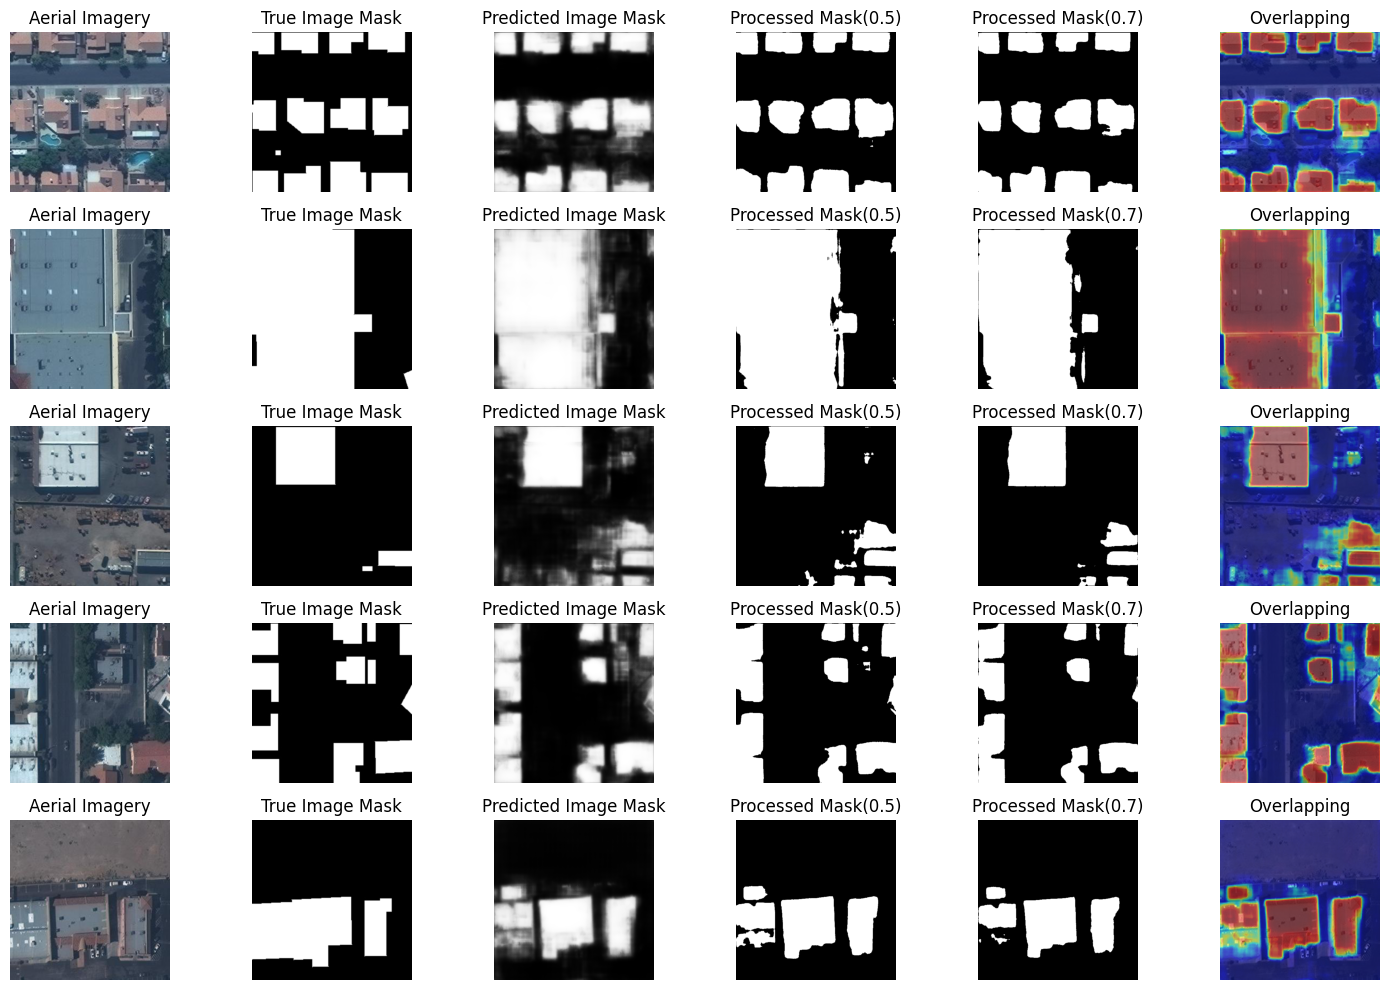

Epoch 32/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, val_loss=0.1558, val_acc=0.9084]



Epoch 32/100 - 37.78s
训练损失: 0.2004 - 训练准确率: 0.8870
验证损失: 0.1558 - 验证准确率: 0.9084
保存最佳模型 (验证损失: 0.1558)


Epoch 33/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, val_loss=0.1594, val_acc=0.9046]



Epoch 33/100 - 38.22s
训练损失: 0.2074 - 训练准确率: 0.8840
验证损失: 0.1594 - 验证准确率: 0.9046


Epoch 34/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, val_loss=0.1534, val_acc=0.9077]



Epoch 34/100 - 37.94s
训练损失: 0.1991 - 训练准确率: 0.8873
验证损失: 0.1534 - 验证准确率: 0.9077
保存最佳模型 (验证损失: 0.1534)


Epoch 35/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, val_loss=0.1531, val_acc=0.9074]



Epoch 35/100 - 37.88s
训练损失: 0.1923 - 训练准确率: 0.8903
验证损失: 0.1531 - 验证准确率: 0.9074
保存最佳模型 (验证损失: 0.1531)


Epoch 36/100 [验证]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, val_loss=0.1485, val_acc=0.9106]



Epoch 36/100 - 38.27s
训练损失: 0.1955 - 训练准确率: 0.8889
验证损失: 0.1485 - 验证准确率: 0.9106
保存最佳模型 (验证损失: 0.1485)


Epoch 37/100 [训练]:  38%|███▊      | 23/61 [00:15<00:20,  1.83it/s, train_loss=0.1536, train_acc=0.9088]

In [ ]:
trained_model, history = train_model(
        model=model,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device
    )